In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load Data

In [3]:
import pandas as pd

In [4]:
# train_Xy = pd.read_csv('../review_comment_retriever/data/train_Xy.csv')
# val_Xy = pd.read_csv('../review_comment_retriever/data/val_Xy.csv')
# test_Xy = pd.read_csv('../review_comment_retriever/data/test_Xy.csv')

In [5]:
train_Xy = pd.read_csv('exploratory_data_analysis/data_teammates/train_Xy.csv')
val_Xy = pd.read_csv('exploratory_data_analysis/data_teammates/val_Xy.csv')
test_Xy = pd.read_csv('exploratory_data_analysis/data_teammates/test_Xy.csv')

In [6]:
train_Xy.head()

augmented_diff_hunk  \
0  --- TimeHelper.java\n+++ TimeHelper.java\n@@ -...   
1  --- InstructorFeedbackAbstractAction.java\n+++...   
2  --- AdminActivityLogPageData.java\n+++ AdminAc...   
3  --- FeedbackResendLinksAction.java\n+++ Feedba...   
4  --- FeedbackResponseAttributesTest.java\n+++ F...   

                                                body  
0  See if it can be defined in one place and used...  
1  Also capitalise the first letter (applies to a...  
2   Not from your PR but is this constant a typo? \n  
3  Should use `FieldValidator` instead of handlin...  
4  Following the discussion from https://github.c...

In [7]:
val_Xy.head()

augmented_diff_hunk  \
0  --- InstructorFeedbackEditPageData.java\n+++ I...   
1  --- FeedbackNumericalScaleQuestionDetails.java...   
2  --- InstructorCourseDetailsPageData.java\n+++ ...   
3  --- FeedbackResponseCommentAttributes.java\n++...   
4  --- InstructorFeedbackEditCopyAction.java\n+++...   

                                                body  
0  I wonder if it will be better if we just retur...  
1  No need to check for null if hiddenRecipients ...  
2  Split this method into multiple methods.\nIt's...  
3  A quick comment:\r\nThis field should remain a...  
4           this line break is unnecessary, right?\n

In [8]:
test_Xy.head()

augmented_diff_hunk  \
0  --- EntityAttributes.java\n+++ EntityAttribute...   
1  --- FeedbackResendLinksAction.java\n+++ Feedba...   
2  --- InstructorFeedbackResultsQuestionTable.jav...   
3  --- AdminActivityLogPageData.java\n+++ AdminAc...   
4  --- CreateFeedbackResponseActionTest.java\n+++...   

                                                body  
0  ```java\r\n* @param error a potentially empty ...  
1       This feature does not require authentication  
2  Does the method and attribute require the "Que...  
3  Should be `* Returns true ...` ?\r\nOverview s...  
4  `nonEmptyPreviewParam` should be a valid stude...

In [9]:
def consolidate_data(df):
    return df.to_dict(orient='records')

In [10]:
train_data = consolidate_data(train_Xy)
val_data = consolidate_data(val_Xy)
test_data = consolidate_data(test_Xy)

In [11]:
len(train_data)

7629

In [12]:
len(val_data)

1347

In [13]:
len(test_data)

1225

## Data Preprocessing

In [14]:
import torch
from transformers import *

review_max_length = 100
review_pretrained_weights = 'bert-base-uncased'
review_tokenizer = BertTokenizer.from_pretrained(review_pretrained_weights)

In [15]:
from collections import Counter
character_counts = Counter()

# only count for train and val
for record in train_data:
    character_counts.update(record['augmented_diff_hunk'])
for record in val_data:
    character_counts.update(record['augmented_diff_hunk'])

In [16]:
diff_max_length = 400

special_character = ["<START>", "UNK", "PAD"]
characters = special_character + [w for w, c in character_counts.most_common(100)]
c2i = {c: i for i, c in enumerate(sorted(characters))}
i2c = {v: k for k, v in c2i.items()}

unkI, padI, startI = c2i['UNK'], c2i['PAD'], c2i['<START>']

In [17]:
print(characters)

['<START>', 'UNK', 'PAD', ' ', 'e', 't', 's', 'i', 'a', 'n', 'r', 'o', 'u', 'c', 'l', '\n', 'd', 'm', '+', '.', 'p', 'g', 'S', '(', ')', 'b', 'E', ';', 'T', 'I', ',', '"', 'f', 'A', 'C', 'v', '-', 'R', 'h', 'F', 'N', 'P', '_', 'k', 'y', '=', 'O', 'D', 'w', 'L', 'M', '@', '1', '{', 'x', 'q', 'U', '/', 'B', '}', 'Q', '*', 'j', '0', '>', '<', 'H', 'G', '2', 'V', 'W', 'K', ':', '3', '|', '\\', '5', 'z', '4', ']', '[', '6', '7', '9', '8', '&', '!', 'Y', 'X', "'", 'J', 'Z', '?', '$', '#', '%', '`', '\t', '\r', '^', '~', 'ú', 'ö']


In [18]:
len(characters)

103

In [19]:
import json
with open('review_to_code/saved_data/review_to_code_c2i.json', 'w') as f:
    json.dump(c2i, f)
with open('review_to_code/saved_data/review_to_code_i2c.json', 'w') as f:
    json.dump(i2c, f)

In [20]:
import numpy as np
from nltk import tokenize

In [21]:
import re

def numerize_diff_hunk(diff_hunk):
    return [c2i.get(c, unkI) for c in diff_hunk]

def pad_sequence(numerized):
    pad = numerized[:diff_max_length]
    padded = pad + [padI] * (diff_max_length - len(pad))
    return padded

def calculate_mask(padded):
    return [c != padI for c in padded]

def preprocess(data):
    for record in data:
        clean_review = re.sub(r'`.+`', '', record['body'].replace("\n", " "))
        
        dict_data = review_tokenizer.encode_plus(clean_review, max_length=review_max_length, pad_to_max_length=True)
        record['review_encoded'] = np.array(dict_data['input_ids'])
        record['review_mask'] = np.array(dict_data['attention_mask'])
        
        record['diff_hunk_encoded'] = pad_sequence(numerize_diff_hunk(record['augmented_diff_hunk']))
        record['diff_hunk_mask'] = calculate_mask(record['diff_hunk_encoded'])

In [22]:
preprocess(train_data)
preprocess(val_data)
preprocess(test_data)

In [23]:
def numerized_to_diff(numerized):
    return "".join([i2c.get(i) for i in numerized])

In [24]:
train_data[0]['augmented_diff_hunk']

'--- TimeHelper.java\n+++ TimeHelper.java\n@@ -28,7 +28,8 @@\n     static{\n         map("-12.0", "Baker Island, Howland Island");\n         map("-11.0", "American Samoa, Niue");\n-        map("-10.0", "Hawaii, Cook Islands, Marquesas Islands");\n+        map("-10.0", "Hawaii, Cook Islands");\n+        map("-9.5", "Marquesas Islands");'

In [25]:
numerized_to_diff(train_data[0]['diff_hunk_encoded'])

'--- TimeHelper.java\n+++ TimeHelper.java\n@@ -28,7 +28,8 @@\n     static{\n         map("-12.0", "Baker Island, Howland Island");\n         map("-11.0", "American Samoa, Niue");\n-        map("-10.0", "Hawaii, Cook Islands, Marquesas Islands");\n+        map("-10.0", "Hawaii, Cook Islands");\n+        map("-9.5", "Marquesas Islands");PADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPAD'

In [26]:
for i in np.random.choice(len(train_data), 3):
    print(review_tokenizer.convert_ids_to_tokens(train_data[i]['review_encoded']))
    print(train_data[i]['review_encoded'])
    print(train_data[i]['review_mask'])

['[CLS]', 'we', 'use', '4', '-', 'space', 'ind', '##entation', 'for', 'java', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[  101  2057  2224  1018  1011  2686 27427 19304  2005  9262   102     0
     0     0     0     0     0     0   

## Build Batch

In [27]:
def build_batch(dataset, batch_size):
    indices = list(np.random.randint(0, len(dataset), size=min(batch_size, len(dataset))))
    
    batch = [dataset[i] for i in indices]
    
    y_encoded = np.array([element['diff_hunk_encoded'] for element in batch])
    start_tokens = np.full((batch_size, 1), startI)
    y_input = np.concatenate((start_tokens, y_encoded), axis=1)
    y_input = y_input[:, :-1]
    
    y_target = y_encoded
    
    y_target_mask = np.array([a['diff_hunk_mask'] for a in batch])
    
    X_encoded = np.array([element['review_encoded'] for element in batch])
    X_mask = np.array([element['review_mask'] for element in batch])

    return X_encoded, X_mask, y_input, y_target, y_target_mask

In [28]:
X_encoded, X_mask, y_input, y_target, y_target_mask = build_batch(train_data, 10)

In [29]:
print(X_encoded.shape)
print(X_mask.shape)
print(y_input.shape)
print(y_target.shape)
print(y_target_mask.shape)

(10, 100)
(10, 100)
(10, 400)
(10, 400)
(10, 400)


## Model

In [30]:
import torch
import torch.nn as nn

In [31]:
from review_to_code.models.review_to_code_lstm import ReviewToCodeModelLSTM

In [ ]:
from review_to_code.models.review_to_code_transformer import ReviewToCodeModelTransformer

## Visualization

In [32]:
from util.training_process_recorder import TrainingProcess

## Trainning (Without Fine-Tune BERT Model)

In [33]:
review_to_code_model = ReviewToCodeModelLSTM(
          startI=c2i['<START>'], code_characters_size=len(c2i),
          feature_dim=768 * review_max_length, output_attentions=False, 
          hidden_dim=2048, review_pretrained_weights=review_pretrained_weights,
          character_vec_dim=256)
review_to_code_model = review_to_code_model.to(review_to_code_model.device)

In [ ]:
review_to_code_model = ReviewToCodeModelTransformer(startI=c2i['<START>'], padI=c2i['PAD'],
    code_characters_size=len(c2i), output_attentions=False, 
    review_pretrained_weights=review_pretrained_weights)
review_to_code_model = review_to_code_model.to(review_to_code_model.device)

In [34]:
tp = TrainingProcess()

In [35]:
if torch.cuda.is_available():
    review_to_code_model.load_state_dict(torch.load('review_to_code/saved_data/body_to_code_lstm.save'))
else:
    review_to_code_model.load_state_dict(torch.load('review_to_code/saved_data/body_to_code_lstm.save', 
                                                    map_location=torch.device('cpu')))

review_to_code_model.eval();
tp.load("review_to_code/saved_data/body_to_code_lstm_tp.save")

In [ ]:
if torch.cuda.is_available():
    review_to_code_model.load_state_dict(torch.load('review_to_code/saved_data/body_to_code_transformer.save'))
else:
    review_to_code_model.load_state_dict(torch.load('review_to_code/saved_data/body_to_code_transformer.save', 
                                                    map_location=torch.device('cpu')))

review_to_code_model.eval();
tp.load("review_to_code/saved_data/body_to_code_transformer_tp.save")

In [ ]:
params = list(review_to_code_model.parameters())
optimizer = torch.optim.Adam(params, lr=0.0002, weight_decay=0.0003)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.995)

num_epochs = 25
batch_size = 64
log_step = 30

for epoch in range(num_epochs):
    num_train = len(train_data)
    iterations_per_epoch = max(num_train // batch_size, 1)
    
    for i in range(iterations_per_epoch):
        minibatch = build_batch(train_data, batch_size)
        X_encoded, X_mask, y_input, y_target, y_target_mask = minibatch
        review_to_code_model.train()
        review_to_code_model.zero_grad()
        loss = review_to_code_model(X_encoded, X_mask, y_input, y_target, y_target_mask)
        loss.backward()
        optimizer.step()
        
        tp.record_train(loss.item())
        tp.step()
        
        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i, iterations_per_epoch, loss.item()))

    val_minibatch = build_batch(val_data, batch_size)
    val_X_encoded, val_X_mask, val_y_input, val_y_target, val_y_target_mask = val_minibatch
    review_to_code_model.eval()
    review_to_code_model.zero_grad()
    val_loss = review_to_code_model(val_X_encoded, val_X_mask, val_y_input, val_y_target, val_y_target_mask)
    
    tp.record_val(val_loss.item())
    
    print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, val_loss.item()))
    
    tp.record_epoch()
    
    my_lr_scheduler.step()

In [ ]:
for i in range(len(test_data) // 64):
    test_minibatch = build_batch(test_data, 64)
    test_X_encoded, test_X_mask, test_y_input, test_y_target, test_y_target_mask = test_minibatch
    review_to_code_model.eval()
    review_to_code_model.zero_grad()
    test_loss = review_to_code_model(test_X_encoded, test_X_mask, test_y_input, test_y_target, test_y_target_mask)

    tp.record_test(test_loss.item())

    print('[Round {}] Test Loss: {:.4f}'.format(i + 1, test_loss.item()))

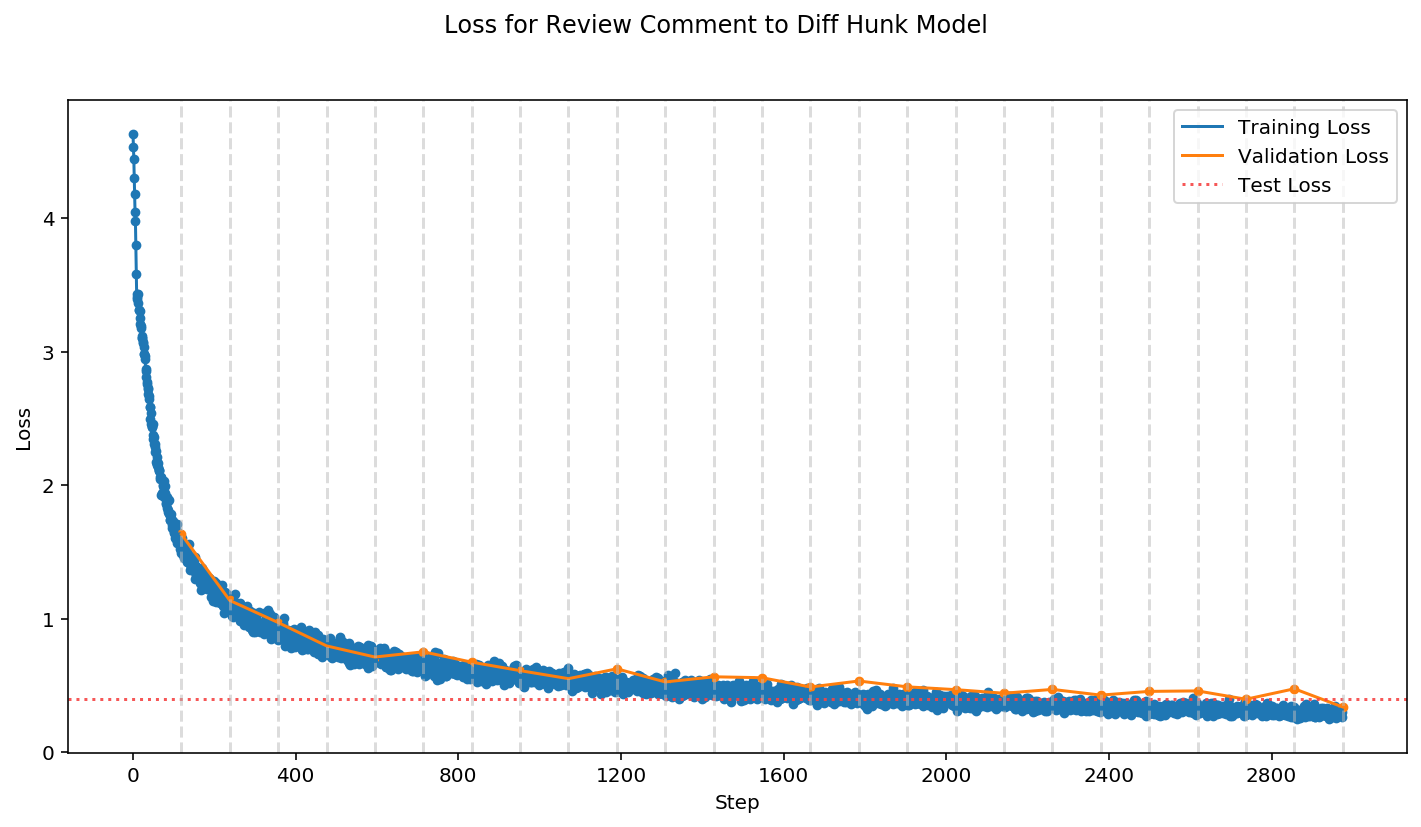

In [36]:
tp.visualize(title='Loss for Review Comment to Diff Hunk Model')

In [ ]:
torch.save(review_to_code_model.state_dict(), 'review_to_code/saved_data/body_to_code_lstm.save')
tp.save('review_to_code/saved_data/body_to_code_lstm_tp.save')

In [ ]:
torch.save(review_to_code_model.state_dict(), 'review_to_code/saved_data/body_to_code_transformer.save')
tp.save('review_to_code/saved_data/body_to_code_transformer_tp.save')

## Generation

In [37]:
text_lst = [record['body'] for record in train_data[:10]]
dict_data = review_tokenizer.batch_encode_plus(text_lst, max_length=review_max_length, pad_to_max_length=True)
text_encoded = np.array(dict_data['input_ids'])
text_mask = np.array(dict_data['attention_mask'])

numerized_list, _ = review_to_code_model.sample(text_encoded, text_mask, beam_size=4, topK=1)
real_numberized_list = [record['diff_hunk_encoded'] for record in train_data[:10]]

for numerized, real_numberized  in zip(numerized_list, real_numberized_list):
    print(numerized_to_diff(real_numberized))
    for n in numerized:
        print(numerized_to_diff(n))
        print('\n')
    print('\n\n')

--- TimeHelper.java
+++ TimeHelper.java
@@ -28,7 +28,8 @@
     static{
         map("-12.0", "Baker Island, Howland Island");
         map("-11.0", "American Samoa, Niue");
-        map("-10.0", "Hawaii, Cook Islands, Marquesas Islands");
+        map("-10.0", "Hawaii, Cook Islands");
+        map("-9.5", "Marquesas Islands");PADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPADPAD
--- InstructorFeedbackResultsPageDataTest.java
+++ InstructorFeedbackResultsPageDataTest.java
@@ -0,0 +1,158 @@
+package teammates.test.cases.ui.pagedata;
+
+import static org.testng.AssertJUnit.asser





--- InstructorFeedbackAbstractAction.java
+++ InstructorFeedbackAbstractAction.java
@@ -0,0 +1,169 @@
+package teammates.ui.controller;
+
+import java.util.ArrayList;
+import java.util.Arrays;
+import java.util.Collections;
+import java.util.Compara

In [38]:
text_lst = ['I think this is a good implementation', 'good job', 'ok', '+1', 
            'can you change this', 'this is bad practice', 'test convention']

dict_data = review_tokenizer.batch_encode_plus(text_lst, max_length=review_max_length, pad_to_max_length=True)
text_encoded = np.array(dict_data['input_ids'])
text_mask = np.array(dict_data['attention_mask'])

numerized_list, _ = review_to_code_model.sample(text_encoded, text_mask, beam_size=4, topK=1)
for numerized in numerized_list:
    for n in numerized:
        print(numerized_to_diff(n))
        print('\n')
    print('\n\n')

--- InstructorFeedbackResultsPageDataTest.java
+++ InstructorFeedbackResultsPageDataTest.java
@@ -0,0 +1,158 @@
+package teammates.test.cases.ui.pagedata;
+
+import static org.testng.AssertJUnit.asser





--- InstructorFeedbackResultsPageDataTest.java
+++ InstructorFeedbackResultsPageDataTest.java
@@ -0,0 +1,158 @@
+package teammates.test.cases.ui.pagedata;
+
+import static org.testng.AssertJUnit.asser





--- InstructorFeedbackResultsPageDataTest.java
+++ InstructorFeedbackResultsPageDataTest.java
@@ -0,0 +1,158 @@
+package teammates.test.cases.ui.pagedata;
+
+import static org.testng.AssertJUnit.asser





--- InstructorFeedbackEditPageDataTest.java
+++ InstructorFeedbackEditPageDataTest.java
@@ -0,0 +1,135 @@
+package teammates.test.cases.ui.pagedata;
+
+import static org.testng.AssertJUnit.assertEqual





--- InstructorCourseStudentDetailsPageDataTest.java
+++ InstructorCourseStudentDetailsPageDataTest.java
@@ -0,0 +1,19 @@
+package teammates.test.cases.ui.pagedata;
+
+import st